Importing modules

In [1]:
import tensorflow as tf
import os
import numpy as np

import matplotlib.pyplot as plt

if not os.path.isdir('models'):
    os.mkdir('models')

print('tenserflow version:', tf.__version__)

tenserflow version: 2.1.0


Preprocess data

In [4]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y==0.)
    indices_1, _ = np.where(y==1.)
    indices_2, _ = np.where(y==2.)
    
    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    x=x[indices]
    y=y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

Visualizing Data

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


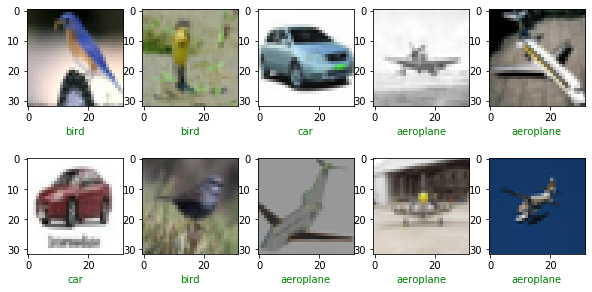

In [6]:
class_names = ['aeroplane', 'car', 'bird']
def show_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace = False)
    x = x[indices]
    y = y[indices]
    p = p[indices]
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[i])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()
    
show_examples(x_train, y_train, y_train)

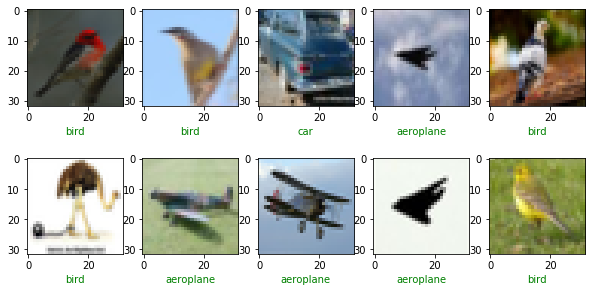

In [8]:
show_examples(x_test, y_test, y_test)

Normalizing Data

In [7]:
x_train = x_train/255.
x_test = x_test/255.

Creating model

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.models import Sequential

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    #compiling model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)       

In [18]:
h = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 10,
    batch_size = 128,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True,
            save_weights_only=False,
            monitor='val_accuracy'
        )
    ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 49s 3ms/sample - loss: 0.1854 - accuracy: 0.9296 - val_loss: 0.3148 - val_accuracy: 0.8930
Epoch 2/10
15000/15000 [==============================] - 41s 3ms/sample - loss: 0.1835 - accuracy: 0.9319 - val_loss: 0.1978 - val_accuracy: 0.9257
Epoch 3/10
15000/15000 [==============================] - 41s 3ms/sample - loss: 0.1700 - accuracy: 0.9339 - val_loss: 0.1841 - val_accuracy: 0.9307
Epoch 4/10
15000/15000 [==============================] - 39s 3ms/sample - loss: 0.1676 - accuracy: 0.9365 - val_loss: 0.2398 - val_accuracy: 0.9157
Epoch 5/10
15000/15000 [==============================] - 39s 3ms/sample - loss: 0.1600 - accuracy: 0.9396 - val_loss: 0.2782 - val_accuracy: 0.9027
Epoch 6/10
15000/15000 [==============================] - 39s 3ms/sample - loss: 0.1549 - accuracy: 0.9406 - val_loss: 0.1999 - val_accuracy: 0.9207


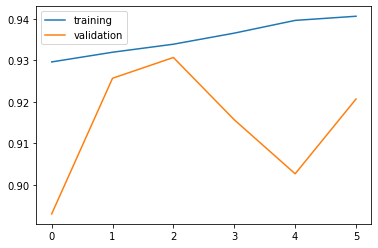

In [19]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='training')
plt.plot(range(len(val_accs)), val_accs, label='validation')
plt.legend()
plt.show()

Predicting data

In [21]:
#selecting best model
model = tf.keras.models.load_model('models/model_0.931.h5')

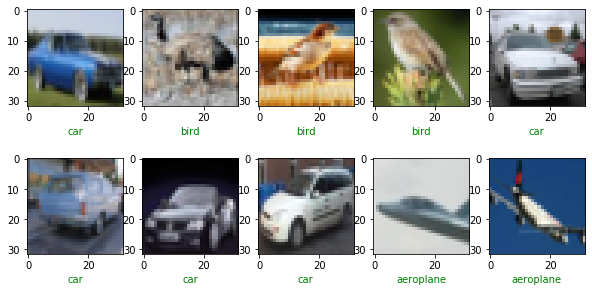

In [24]:
pred = model.predict(x_test)
show_examples(x_test, y_test, pred)